In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve

Physical constants:

In [2]:
EAU = 27.2114
IAU = 3.5e16
LAU = 0.052918
TAU = 2.419e-17
alpha = 1. /137
c = 1/alpha

Field configurations:

In [17]:
#in SI units
wavelength = 800 #e-9 #Wavelength in nm
Int_0 = 4e14 #Intensity in W/cm2
Ip = 0.5 #* 13.5984 # Hydrogen gas target ionization potential in eV

#conversion to atomic units
omega = 2 * np.pi * LAU * c / wavelength  # Angular frequency
TC = 2 * np.pi / omega  # Optical cycle period
E_0 = np.sqrt(Int_0 / IAU)  #field strength
U_pond = (E_0**2) / (4 * omega**2)

print(U_pond)

0.8812603176667388


Defining electric field E(t):

In [18]:
t_list = np.linspace(-TC, TC, 200)  #time list

#two-colour beam, with mixing angle θ and phase shift φ
def beam_TC(theta, phi, r, s):
    Int_1 = Int_0 * (np.cos(theta))**2  #Intensity of beam 1
    Int_2 = Int_0 * (np.sin(theta))**2  #Intensity of beam 1
    omega_1 = r * omega  #Frequency of beam 1
    omega_2 = s * omega  #Frequency of beam 1

    E_01 = np.sqrt(Int_1 / IAU)  #field strength of beam 1
    E_02 = np.sqrt(Int_2 / IAU)  #field strength of beam 2

    e_field = []  #create empty lists to store electric field values for each point in time

    for i in t_list:
        beam_1 = E_01 * np.sin(omega_1 * i)
        beam_2 = E_02 * np.sin((omega_2 * i) + phi)
        total_beam = beam_1 + beam_2

        e_field.append(total_beam)

    return e_field

Defining vector potential A(t):

In [19]:
#vector potential A of TC beam:
def vector_potential_TC(theta, phi, r, s):
    Int_1 = Int_0 * (np.cos(theta))**2  #Intensity of beam 1
    Int_2 = Int_0 * (np.sin(theta))**2  #Intensity of beam 1
    omega_1 = r * omega  #Frequency of beam 1
    omega_2 = s * omega  #Frequency of beam 1

    E_01 = np.sqrt(Int_1 / IAU)  #field strength of beam 1
    E_02 = np.sqrt(Int_2 / IAU)  #field strength of beam 2

    vector_pot = []  
    
    for i in t_list:
        A_1 = (E_01 / omega_1) * np.cos(omega_1 * i)
        A_2 = (E_02 / omega_2) * np.cos((omega_2 * i) + phi)
        A_total = A_1 + A_2

        vector_pot.append(A_total)

    return vector_pot

Plot of electric field and vector potential:

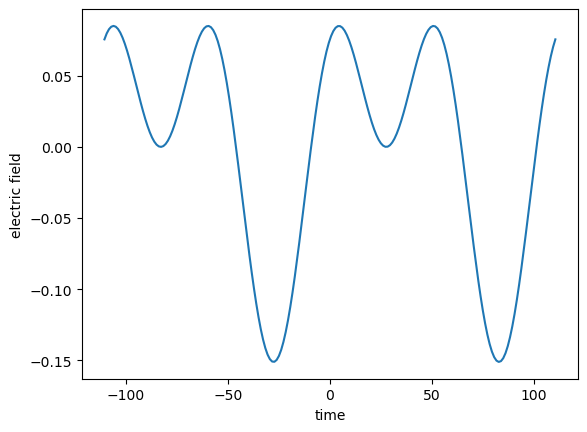

In [20]:
plt.plot(t_list, beam_TC(np.pi / 4, np.pi /2, 1, 2), label='electric field')
#plt.plot(t_list, vector_potential_TC(np.pi / 4, np.pi /2, 1, 2), label='vector potential')

plt.xlabel("time")
plt.ylabel("electric field")
plt.show()

Defining the derivative of the action dS/dt:

In [21]:
def field_strength(theta):
    Int_1 = Int_0 * (np.cos(theta))**2  #Intensity of beam 1
    Int_2 = Int_0 * (np.sin(theta))**2  #Intensity of beam 1

    E_01 = np.sqrt(Int_1 / IAU)  #field strength of beam 1
    E_02 = np.sqrt(Int_2 / IAU)  #field strength of beam 2

    return [E_01, E_02]

field_strength(np.pi/4)[0]      #use [0] to get field strength of beam 1 and [1] for beam 2

0.07559289460184546

In [22]:
#pick mixing angle (theta) to set up electric field amplitudes:
E_01 = field_strength(np.pi/4)[0]
E_02 = field_strength(np.pi/4)[1]

#pick values of r and s to set up frequencies:
omega_1 = omega  #Frequency of beam 1
omega_2 = 2 * omega  #Frequency of beam 2

def action_drv_TC(t_arr):
    #S_mono = Ip*t + 0.5*p**2*t - (p/omega)*np.cos(omega*t + np.pi/2) + 0.5*t - (1/4*omega)*np.sin(2*omega*t + np.pi)
    t = t_arr[0] + t_arr[1]*1j

    dS_dt_TC_real = np.real(Ip + 0.5* (p + (E_01/omega_1) * (np.cos(omega_1 * t)) + (E_02/omega_2) * (np.cos(omega_2 * t) + np.pi/2))**2)   #dS/dt = Ip + (p + A(t))^2 
    dS_dt_TC_imag = np.imag(Ip + 0.5* (p + (E_01/omega_1) * (np.cos(omega_1 * t)) + (E_02/omega_2) * (np.cos(omega_2 * t) + np.pi/2))**2)   #where A(t) = E_0/w * cos(wt + phi)

    return np.array([dS_dt_TC_real, dS_dt_TC_imag])

Finding saddle points:

In [23]:
#p = 0.5507876985417118  #momentum
p = 0


ts = []  #empty list to collect saddle points

for m in np.linspace(0, TC, 10):                             #calculate saddle point for every initial guess in timespace
    for n in np.linspace(0, TC/2, 10):
        #print(m+1j*n)
        saddles = fsolve(action_drv_TC, np.array([m,n]), xtol=1e-10)
        saddles = np.round(saddles, 3)
        
        #print(np.linalg.norm(action_drv_TC(saddles)))
        
        if saddles[0] > 0 and saddles[0] < TC:                                   #only keep saddle points with positive real/imag times
            if saddles[1] > 0 and saddles[1] < TC/2:
                if np.linalg.norm(action_drv_TC(saddles)) < 1:
                    ts.append(saddles)

saddle_points = [complex(t[0], t[1]) for t in ts]            # Convert (real, imag) pairs to complex numbers

saddle_points = np.unique(np.round(saddle_points, 3))        # Round to 6 d.p., then remove duplicates

print(saddle_points)

[26.108+10.446j 34.417 +4.626j 36.287 +5.792j 43.234+15.471j
 67.114+15.471j 74.061 +5.792j 75.932 +4.626j 84.24 +10.446j]


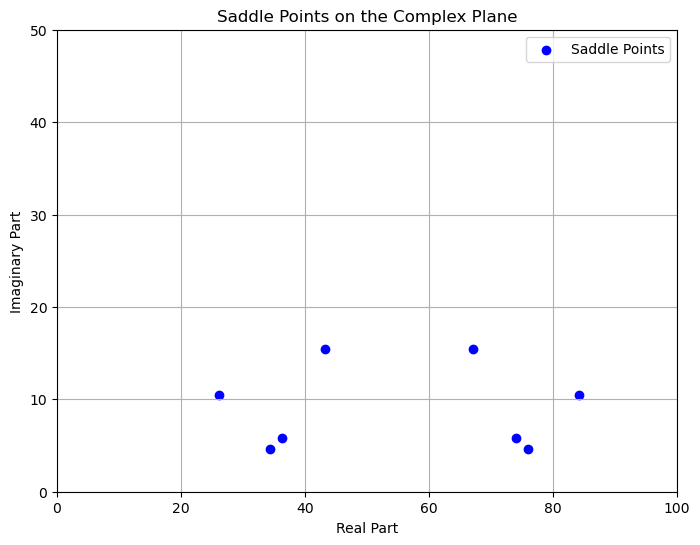

In [24]:
reals = []
imags = []

for point in saddle_points:
    real_part = np.real(point)
    reals.append(real_part)
    
    imag_part = np.imag(point)
    imags.append(imag_part)

plt.figure(figsize=(8, 6))
plt.scatter(reals, imags, color='blue', label='Saddle Points')

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.xlim(0, 100)  # Set x-axis range (e.g., from 0 to 10)
plt.ylim(0, 50)  # Set y-axis range (e.g., from 0 to 10)
plt.title('Saddle Points on the Complex Plane')
plt.grid(True)
plt.legend()
plt.show()

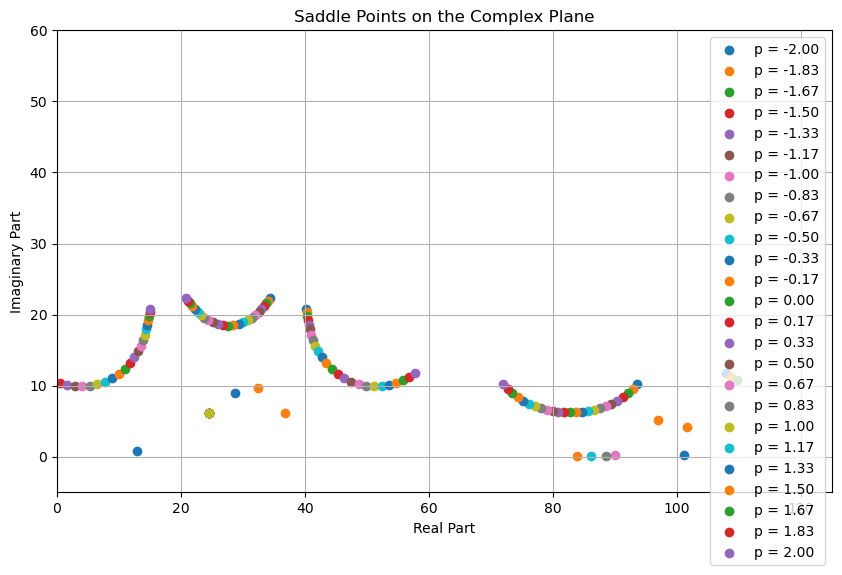

In [26]:
momentum = np.linspace(-2.0, 2.0, 25)

plt.figure(figsize=(10, 6))

for p in momentum:
    
    ts = []
    
    def action_drv_TC(t_arr):
        t = t_arr[0] + t_arr[1]*1j

        dS_dt_TC_real = np.real(Ip + 0.5* (p + (E_01/omega_1) * (np.cos(omega_1 * t)) + (E_02/omega_2) * np.cos(omega_2 * t + np.pi/2))**2)   #dS/dt = Ip + (p + A(t))^2 
        dS_dt_TC_imag = np.imag(Ip + 0.5* (p + (E_01/omega_1) * (np.cos(omega_1 * t)) + (E_02/omega_2) * np.cos(omega_2 * t + np.pi/2))**2)   #where A(t) = E_0/w * co

        return np.array([dS_dt_TC_real, dS_dt_TC_imag])

    for m in np.linspace(0, TC, 10):                             #calculate saddle point for every initial guess in timespace
        for n in np.linspace(0, TC/2, 10):
            #print(m+1j*n)
            saddles = fsolve(action_drv_TC, np.array([m,n]), xtol=1e-8)
            saddles = np.round(saddles, 3)

            if saddles[0] > 0 and saddles[0] < TC:                                   #only keep saddle points with positive real/imag times
                if saddles[1] > 0 and saddles[1] < TC/2:
                    if np.linalg.norm(action_drv_TC(saddles)) < 1: # 1 is a numerical tolerance set heuristically at the monochromatic fields
                        ts.append(saddles)

    saddle_points = [complex(t[0], t[1]) for t in ts]            # Convert (real, imag) pairs to complex numbers
    saddle_points = np.unique(np.round(saddle_points, 3))        # Round to 6 d.p., then remove duplicates

    reals = []
    imags = []

    for point in saddle_points:
        real_part = np.real(point)
        reals.append(real_part)

        imag_part = np.imag(point)
        imags.append(imag_part)

    plt.scatter(reals, imags, label=f'p = {p:.2f}')


plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.xlim(0, 125)  # Set x-axis range (e.g., from 0 to 10)
plt.ylim(-5, 60)  # Set y-axis range (e.g., from 0 to 10)
plt.title('Saddle Points on the Complex Plane')
plt.grid(True)
plt.legend()
plt.show()

Plotting trajectory:

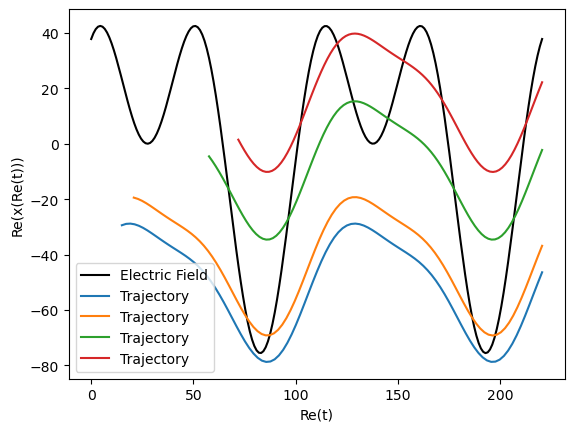

In [27]:
#initialize value of phase shift (phi)
phi = np.pi/4

# Create a figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlabel("Re(t)")
ax.set_ylabel("Re(x(Re(t)))")

# Plot the electric field
times = np.linspace(0.0, 2 * TC, 200)  # 200 time points
electric_field = [i*500 for i in beam_TC(np.pi / 4, np.pi /2, 1, 2)]

ax.plot(times, electric_field, color="black", label="Electric Field")


#Plot the trajectories
for sad in saddle_points:
    real_times = np.linspace(np.real(sad), 2*TC, 100)

    positions = []
    
    for t in real_times:
        integrated_A_t = (E_01/omega_1**2) * np.sin(omega_1*t) + (E_02/omega_2**2) * np.sin(omega_2*t + phi)
        integrated_A_ts = (E_01/omega_1**2) * np.sin(omega_1*sad) + (E_02/omega_2**2) * np.sin(omega_2*sad + phi)
        integrated_A = integrated_A_t - integrated_A_ts
    
        positions.append(integrated_A)


    ax.plot(real_times, np.real(positions), linestyle="solid", label="Trajectory")

plt.legend()
plt.show()
